#### MAIT Cell Plotting and Analysis
In this notebook, we will be labeling and analyzing MAIT cells, and looking at them in the embedding space, using both their CDR3 sequence embedding on the sequence level and single cell level.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ..

/home/romi/projects/cvc


In [4]:
import os, sys
import collections
import importlib
import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import ast

import anndata as ad
import scanpy as sc

SRC_DIR = "cvc"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)

from cvc import model_utils
from cvc import plot_utils
from cvc import utils
from single_cell_research import cvc_sequencing as cs
from lab_notebooks.utils import SC_TRANSFORMER, TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/cvc_2.0")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

'plots/cvc_2.0'

#### Load data

In [6]:
data_dir = DATA_DIR + "10x_nsclc_tra_trb_df.csv" #"tra_to_trb_mapping_100k_scData.csv"#"public_private_scData_100k.csv"
# directory to save MAIT cell labeled data
output_dir = "./single_cell_research/10x_nsclc/MAIT_all_seqs_df.csv"

In [7]:
# load data db
embed_data = pd.read_csv(data_dir, engine="pyarrow")
# rename sequences column if not named "Sequences"
embed_data.rename(columns={'cdr3': 'Sequences'}, inplace=True)

In [8]:
embed_data

,,contig_id,sequence,barcode,is_cell,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,Sequences,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
0,0,AAGACCTCATTTGCCC-1_contig_1,TGGGGGCTGTTGCTCACAGTGACCCTGATTGGGCAAAGCTCCCATC...,AAGACCTCATTTGCCC-1,True,True,511,TRB,TRBV11-2,TRBD1,TRBJ1-1,TRBC1,True,True,CASSSQGGTEAFF,TGTGCCAGCAGCTCCCAGGGTGGGACTGAAGCTTTCTTT,7070,5,clonotype194,clonotype194_consensus_2
1,1,AAGACCTCATTTGCCC-1_contig_3,TGGGGAGAGTGTTTATCTTGTGAGCCATTCTCCATATTTCAGATAT...,AAGACCTCATTTGCCC-1,True,True,529,TRA,TRAV21,None,TRAJ52,TRAC,True,True,CAVAPAGGTSYGKLTF,TGTGCTGTGGCCCCTGCTGGTGGTACTAGCTATGGAAAGCTGACATTT,4152,3,clonotype194,clonotype194_consensus_1
2,2,AAGGCAGCAAGTAATG-1_contig_1,GGGTTTCTGAGGCCCAAATAGCTGAAGAGGTGGAGACGTTACAGAA...,AAGGCAGCAAGTAATG-1,True,True,616,TRB,TRBV27,TRBD2,TRBJ2-7,TRBC2,True,True,CASSLYGRSYEQYF,TGTGCCAGCAGTTTATACGGGCGGTCCTACGAGCAGTACTTC,17459,18,clonotype15,clonotype15_consensus_2
3,3,AAGGCAGCAAGTAATG-1_contig_2,GGGGAGAAACCACTATGATTGTTAGAGGAAAGAAAGGAATACCCGA...,AAGGCAGCAAGTAATG-1,True,True,747,TRA,TRAV13-2,None,TRAJ28,TRAC,True,True,CAENDSGAGSYQLTF,TGTGCAGAGAATGACTCTGGGGCTGGGAGTTACCAACTCACTTTC,5129,4,clonotype15,clonotype15_consensus_1
4,4,AAGGCAGCAAGTAATG-1_contig_3,TGGGAACTGTGTTTTCTAAATAGCTAAGGGATGGAGACTGTTCTGC...,AAGGCAGCAAGTAATG-1,True,True,659,TRA,TRAV34,None,TRAJ38,TRAC,True,False,CGADQGWQQP*ADL,TGTGGAGCAGACCAAGGCTGGCAACAACCGTAAGCTGATTTG,2718,2,clonotype15,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3638,5092,GGGTTGCTCCGAACGC-1_contig_3,GGGAGCCAGTACATAGAGAAGTGTGAGGTGACACACACTAGTTTGC...,GGGTTGCTCCGAACGC-1,True,True,650,TRA,TRAV14DV4,None,TRAJ5,TRAC,True,True,CAMRGRDTGRRALTF,TGTGCAATGAGAGGTCGGGACACGGGCAGGAGAGCACTTACTTTT,17250,18,clonotype1130,clonotype1130_consensus_2
3639,5093,TCATTACCACCAGCAC-1_contig_1,TGGGGAGAGCCCAGCACCTCACCCAGAGGACCCCAGTCAGAGGCCC...,TCATTACCACCAGCAC-1,True,True,536,TRB,TRBV4-3,TRBD2,TRBJ2-2,TRBC2,True,True,CASSPTSGFAGELFF,TGCGCCAGCAGTCCCACTAGCGGGTTTGCCGGGGAGCTGTTTTTT,11698,11,clonotype5,clonotype5_consensus_2
3640,5094,TCATTACCACCAGCAC-1_contig_4,ATTGATCCTTTTCTTATATGGGGGTTGAATACACAAGTCAACTTCT...,TCATTACCACCAGCAC-1,True,True,543,TRA,TRAV10,None,TRAJ6,TRAC,True,True,CVVSESGGSYIPTF,TGTGTGGTGAGCGAATCAGGAGGAAGCTACATACCTACATTT,3067,5,clonotype5,clonotype5_consensus_1
3641,5097,TGGTTAGAGAGGGCTT-1_contig_1,GGGGAGTGGAAACCACAGCCTAGTCCTCTCACCACTGCAGACCAGA...,TGGTTAGAGAGGGCTT-1,True,True,710,TRB,TRBV3-1,None,TRBJ2-5,TRBC2,True,True,CASSQERIQETQYF,TGTGCCAGCAGCCAAGAAAGGATTCAGGAGACCCAGTACTTC,8758,10,clonotype1424,clonotype1424_consensus_1


#### Prepare data - label MAIT cells
Label MAIT cells by their TRA CDR3 sequence.
We will use the following criteria:  if the v_gene is "TRAV1-2" and j_gene is TRAJ33 or TRAJ20 or TRAJ12.


In [9]:
# extract the TRA chain
embed_data_tra = embed_data[embed_data['chain'] == 'TRA']

# create "MAIT_cell" column if the v_gene is "TRAV1-2" and j_gene is TRAJ33 or TRAJ20 or TRAJ12
embed_data_tra['MAIT_cell'] = np.where((embed_data_tra['v_gene'] == 'TRAV1-2') &
                                       (embed_data_tra['j_gene'].isin(['TRAJ33', 'TRAJ20', 'TRAJ12'])), 'MAIT_cell', 'non-MAIT_cell')

# extract the list of barcodes from the dataframe that are MAIT cells
MAIT_barcodes = embed_data_tra[embed_data_tra['MAIT_cell'] == 'MAIT_cell']['barcode'].tolist()

# create a column in embed_data that is MAIT_cell if the barcode is in the MAIT_barcodes list, and non-MAIT_cell otherwise
embed_data['MAIT_cell'] = np.where(embed_data['barcode'].isin(MAIT_barcodes), 'MAIT_cell', 'non-MAIT_cell')
embed_data.to_csv(output_dir, index=False)

/tmp/ipykernel_8959/1356523014.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embed_data_tra['MAIT_cell'] = np.where((embed_data_tra['v_gene'] == 'TRAV1-2') &


##### Extract TRB features of MAIT cells

In [10]:
embed_data_TRB = embed_data[embed_data['chain'] == 'TRB']
# investigate TRBV20 or TRBV6
df_TRB_MAIT = embed_data_TRB
df_TRB_MAIT['v_gene_group'] = df_TRB_MAIT['v_gene'].str.split('-').str[0]
df_TRB_MAIT['v_gene_6_20'] = np.where(df_TRB_MAIT['v_gene_group'].str.contains('TRBV20|TRBV6'), df_TRB_MAIT['v_gene_group'], 'other')

/tmp/ipykernel_8959/468815418.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TRB_MAIT['v_gene_group'] = df_TRB_MAIT['v_gene'].str.split('-').str[0]
/tmp/ipykernel_8959/468815418.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TRB_MAIT['v_gene_6_20'] = np.where(df_TRB_MAIT['v_gene_group'].str.contains('TRBV20|TRBV6'), df_TRB_MAIT['v_gene_group'], 'other')


In [11]:
# Look at the distribution of TRBV20 and TRBV6 genes in the MAIT cells
df_TRB_MAIT['MAIT_cell_sub'] = np.where((df_TRB_MAIT['MAIT_cell'] == 'MAIT_cell') &
                                   (df_TRB_MAIT['v_gene_group'] == 'TRBV20'), 'MAIT_cell_TRBV20',
                                   np.where((df_TRB_MAIT['MAIT_cell'] == 'MAIT_cell') & (df_TRB_MAIT['v_gene_group'] == 'TRBV6'), 'MAIT_cell_TRBV6', df_TRB_MAIT['MAIT_cell']))
# export to csv
df_TRB_MAIT.to_csv("./single_cell_research/10x_nsclc/TRB_MAIT_df.csv")

/tmp/ipykernel_8959/2133059939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TRB_MAIT['MAIT_cell_sub'] = np.where((df_TRB_MAIT['MAIT_cell'] == 'MAIT_cell') &


In [12]:
collections.Counter(embed_data_TRB["MAIT_cell"])

Counter({'non-MAIT_cell': 1720, 'MAIT_cell': 118})

##### Label single cells as MAIT cells

In [13]:
# concatenated single cells
embed_data_edit = embed_data
embed_data_edit.rename(columns={'Sequences': 'cdr3'}, inplace=True)
embed_data_edit.rename(columns={'barcode': 'barcode_unique'}, inplace=True)

seqs_concat = cs.create_tcr_seqs(embed_data_edit)
v_genes_concat = cs.create_tcr_seqs(embed_data_edit, column_to_concat='v_gene')
j_genes_concat = cs.create_tcr_seqs(embed_data_edit, column_to_concat='j_gene')

df_seqs = pd.DataFrame({'Sequences': seqs_concat, 'v_gene': v_genes_concat, 'j_gene': j_genes_concat})
# create "MAIT_cell" column if the v_gene is "TRAV1-2" and j_gene is TRAJ33 or TRAJ20 or TRAJ12
df_seqs['MAIT_cell'] = np.where((df_seqs['v_gene'].str.contains('TRAV1-2')) &
                                (df_seqs['j_gene'].str.contains('TRAJ33|TRAJ20|TRAJ12')), 'MAIT_cell', 'non-MAIT_cell')
# save
df_seqs.to_csv("./single_cell_research/10x_nsclc/concatenated_seqs_df.csv")

100%|███████████████████████████████████| 3642/3642 [00:00<00:00, 835054.67it/s]


#### Create and Display embeddings
Edit parameters below to change the data and transformer used for the embedding.
Display embeddings and color by desired column (change parameters as needed).

In [24]:
# set data and transformer
df_for_embedding = df_TRB_MAIT#df_seqs #embed_data #embed_data_TRB #TRB_df #df_CAVLGDDYKLSF
TRANSFORMER_TO_USE = TRANSFORMER #SC_TRANSFORMER

In [25]:
from cvc.embbeding_wrapper import EmbeddingWrapper

# Create embeddings
embed_wrap = EmbeddingWrapper(TRANSFORMER_TO_USE, DEVICE, df_for_embedding, batch_size=128, method="mean", layers=[-1], pbar=True, max_len=120)
# create anndata object
tcrb_embeddings_adata = embed_wrap.create_anndata(n_comps=50)

# shape of the embeddings
embed_wrap.embeddings.shape

Some weights of the model checkpoint at /home/romi/projects/cvc/output_5mil_even_priv_pub were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/15 [00:00<?, ?it/s]

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(1838, 768)

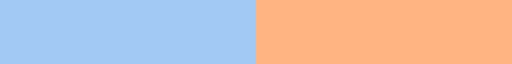

In [26]:
# Create colormap of 16 shades of blues
color_map_2 = ListedColormap(sns.color_palette("pastel", 2))
# color_map_4 = ListedColormap(sns.color_palette("Spectral", 4))
color_map_2

In [28]:
# general arguments
embeddings_to_use = embed_wrap
label_column = 'MAIT_cell' #'MAIT_cell_sub'
color_map_to_use = color_map_2 #color_map_4
plot_title = "UMAP of TRB Embeddings - MAIT Cells" #"UMAP of Single Cell Embeddings, MAIT Cells" #"UMAP of TRB Embeddings - MAIT Cells (with TRBV6/20)"
pdf_path = os.path.join(PLOT_DIR, "umap_MAIT_TRB.svg")

/tmp/ipykernel_8959/31663388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embeddings_to_use.sequences_df.sort_values(by=label_column, inplace=True,  ascending=False)
/opt/conda/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


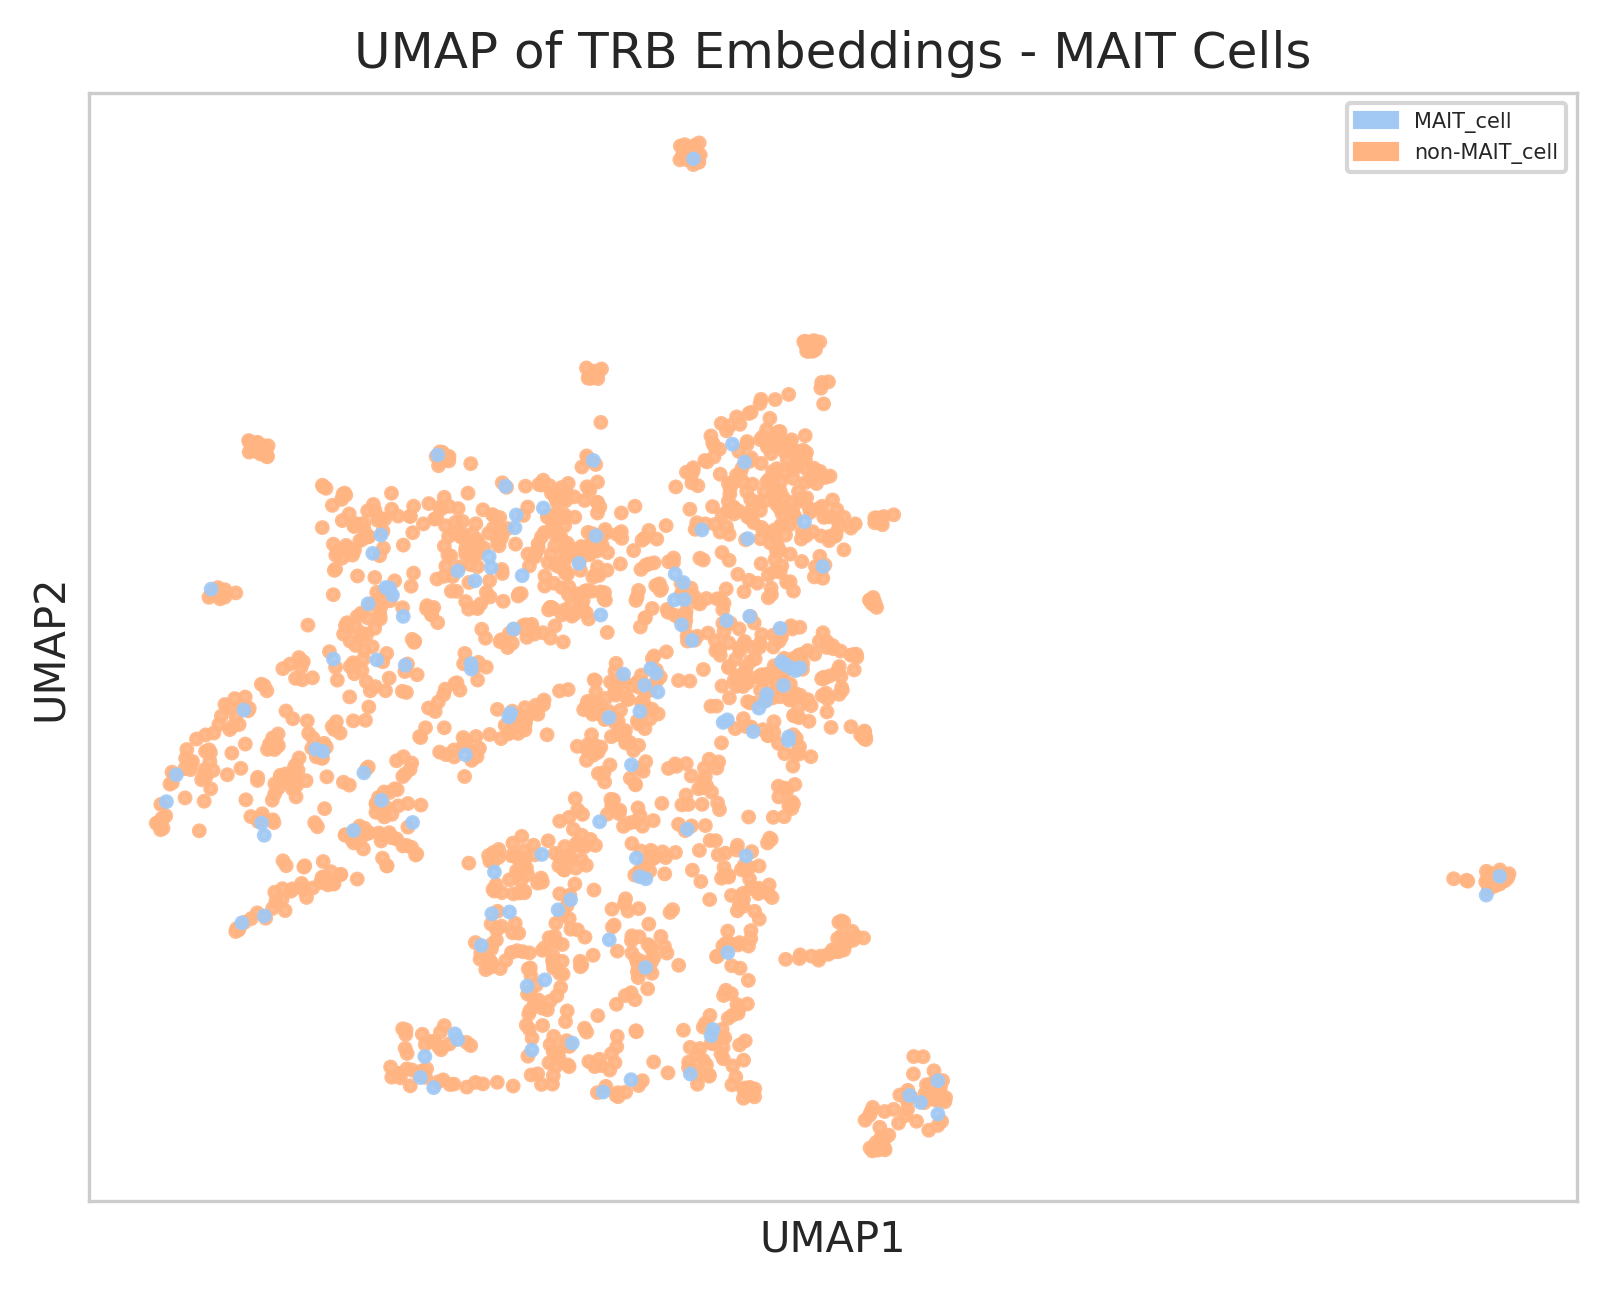

In [30]:
# Plot embeddings (no need to edit)
importlib.reload(plot_utils)
embeddings_to_use.sequences_df.sort_values(by=label_column, inplace=True,  ascending=False)
embeddings_to_use.plot_embedding(
    color_embed=label_column,
    color_map=color_map_to_use,
    title=plot_title,
    legend_size=5,
    plot_pdf_path=pdf_path,
    n_comps=50
)

#### MAIT Cell Publicness
The code below relies on a dataframe that contains the MAIT cell labels and the Public/Private labels.
The Private/Public label can be created using the "binary_classifiers.ipynb" notebook, setting the CLASSIFICATION type to PUBLIC_PRIVATE.

In [5]:
TRB_MAIT_Public_Private = pd.read_csv("./CDR3_data/MAIT_cell_data_embeddings_8_datasets_embeddings_pub_priv.csv")
# TRB_MAIT_Public_Private.drop(columns=["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 1"], inplace=True)
# create new column, MAIT_Puclic_Private, if MAIT_cell is MAIT_cell and Public_Private_Label "1" than MAIT_Public, otherwise MAIT_Private
TRB_MAIT_Public_Private['MAIT_Public_Private'] = \
    np.where((TRB_MAIT_Public_Private['MAIT_cell'] == 'MAIT_cell') &
             (TRB_MAIT_Public_Private['Public_Private_Label'] == 1), 'MAIT_Public',
             np.where((TRB_MAIT_Public_Private['MAIT_cell'] == 'non-MAIT_cell') &(TRB_MAIT_Public_Private['Public_Private_Label'] == 1), 'non-MAIT_Public', 'non-MAIT_Private'))
TRB_MAIT_Public_Private

,0,1,2,3,4,5,6,7,8,9,...,762,763,764,765,766,767,Sequences,MAIT_cell,Public_Private_Label,MAIT_Public_Private
0,-0.149587,-0.197047,-0.606274,0.246161,0.146642,-0.208196,0.247288,-0.079729,0.198015,-0.245093,...,-0.319213,0.780746,-0.412318,0.522235,0.514297,0.207887,CASSVAGLLYEQYF,MAIT_cell,1,MAIT_Public
1,-0.003837,0.004939,-0.305185,-0.467737,0.554620,0.526504,0.037872,-0.058776,0.078017,-0.378901,...,-0.451306,-0.204477,-0.042363,0.488556,0.090419,0.102915,CASSHPPGADLGGQPQHF,MAIT_cell,0,non-MAIT_Private
2,0.027054,0.238266,0.138490,-0.477724,0.421007,0.106373,-0.682291,-0.285417,0.483916,-0.346199,...,0.230915,0.139384,-0.132491,0.416187,0.232041,-0.580679,CAWSVPPVQGDRTQHF,MAIT_cell,0,non-MAIT_Private
3,-0.149578,0.100374,-0.122322,-0.478098,0.454484,0.019130,0.048994,0.235329,0.132402,-0.505863,...,0.008110,-0.087051,-0.256943,0.420582,-0.317372,0.073733,CSARDLDSLTNGYTF,MAIT_cell,0,non-MAIT_Private
4,-0.540540,0.291595,-0.353379,-0.261123,0.426946,0.357447,-0.488219,-0.435053,0.388957,-0.267924,...,0.323352,0.735837,0.272375,0.473237,0.894415,-0.243902,CAWSGEPSQAQYF,MAIT_cell,0,non-MAIT_Private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5011,-0.329775,0.793744,-1.056300,0.181084,0.043187,-0.084797,0.497528,0.468565,0.060517,0.038454,...,-0.516974,0.407369,0.187545,0.344213,0.109828,0.269770,CASTGENNSPLHF,non-MAIT_cell,1,non-MAIT_Public
5012,-0.100326,0.304981,0.190182,-0.059698,0.107292,0.121101,-0.251405,-0.306332,0.125169,-0.237075,...,-0.378466,0.207969,-0.128755,0.727024,0.299680,0.027128,CASSVDWSGPGNTGELFF,non-MAIT_cell,0,non-MAIT_Private
5013,-0.056023,-0.094397,-0.433103,-0.062313,0.069507,-0.040174,0.057963,-0.075291,0.027573,-0.167322,...,-0.047353,0.050179,-0.237840,0.765852,-0.496809,0.229118,CSARALAGGTNEQFF,non-MAIT_cell,1,non-MAIT_Public
5014,-0.422617,0.676036,-1.092209,0.034845,0.449366,0.100408,0.365332,0.275192,0.020950,0.030260,...,-0.774795,0.810294,-0.045002,0.009765,0.297485,0.518775,CASSFQGGDQPQHF,non-MAIT_cell,1,non-MAIT_Public


In [10]:
collections.Counter(TRB_MAIT_Public_Private['MAIT_cell'])

Counter({'MAIT_cell': 2508, 'non-MAIT_cell': 2508})

In [6]:
collections.Counter(TRB_MAIT_Public_Private['MAIT_Public_Private'])

Counter({'MAIT_Public': 1584,
         'non-MAIT_Private': 1931,
         'non-MAIT_Public': 1501})

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


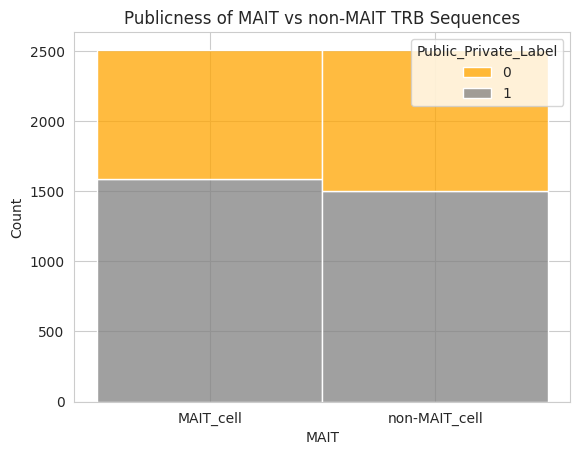

In [9]:
sns.histplot(data=TRB_MAIT_Public_Private, x="MAIT_cell", hue="Public_Private_Label", multiple="stack", palette=['orange', 'gray'])
plt.title('Publicness of MAIT vs non-MAIT TRB Sequences')
plt.xlabel('MAIT')
plt.ylabel('Count')
# save in high quality svg
plt.savefig("./single_cell_research/figures/MAIT_Publicness_bar_8_datasets.svg", format="svg", dpi=1200)
plt.show()

In [8]:
# Calculate percentages of public and private sequences for each MAIT type
counts = TRB_MAIT_Public_Private.groupby(['MAIT_cell', 'Public_Private_Label']).size()
totals = counts.groupby(level=0).transform(lambda x: x.sum())
percentages = (counts / totals * 100).rename('percentage').reset_index()

percentages

,MAIT_cell,Public_Private_Label,percentage
0,MAIT_cell,0,36.842105
1,MAIT_cell,1,63.157895
2,non-MAIT_cell,0,40.151515
3,non-MAIT_cell,1,59.848485
